In [15]:
%matplotlib inline

import pandas as pd
import numpy as np
import scipy as sp
import math

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

import seaborn as sns
import warnings

from sklearn.utils.extmath import cartesian
from itertools import product, combinations
from operator import add
from functools import reduce

warnings.filterwarnings('ignore')
np.random.seed(2017)

%run ../src/stochastic_helpers.py

We are planning to solve more tractable version of this problem which involves a single bag that needs to be filled such that maximum possible weight can be carried.

Hard Constraints:

* Total weight of the bag must be less than 50.
* Atleast 3 items must be included in the bag.
* Total count of items must not exceed their total available count.

Consider solution vector to be something like:

```
solution : [c1, c2, c3, c4, c5, c6, c7, c8, c9]
example  : [8, 2, 3, 1, 0, 0, 1, 2, 1] represents 8 items from type1, 2 items from type2 and so on. 

```

Since each bit in the vector can take values up to maximum possible items for a type it means that solution space is:

$$max\_items\_type\_1 * max\_items\_type\_2 * max\_items\_type\_3 ...$$

in our case it turns out to be: $$1000 * 1100 * 500 * 1000 * 1200 * 1000 * 1000 * 200 * 166 = 21912000000000000000000000$$ possibilites which is huge.

We need to be search the space in much more efficient way.

We can make use of the fact that this is a constrained problem and only those candidates should be considered which actually would satisfy the hard constraints mentioned earlier.

So no need to generate solutions which are most likely to go take the total weight beyond 50 and no need to generate solutions where total number of items in the bag is less than 3.

### Search Space

In [2]:
num_gifts_available = {
    "horse": 1000,
    "ball": 1100,
    "bike": 500,
    "train": 1000,
    "book": 1200,
    "doll": 1000,
    "blocks": 1000,
    "gloves": 200,
    "coal": 166
}

gift_type_std = [  0.301024,  9.782352,  3.084284,  2.018248, \
                 16.646331,  2.244458,  1.408373,  1.972852,  4.904175]

available_count = np.array([num_gifts_available[gift_type] for gift_type in gift_types])

** Question: What if we want to know the maximum number of items that we could add for each of the gift type such that it would not overshoot the total budget ? **

In [3]:
def get_count_estimate(gift_type, quantity, size):
    return custom_sample(gift_type, quantity, size)

def get_count_estimates(gift_types, num_gifts_available):
    max_count_possible = []
    
    for gift_type in gift_types:
        for quantity in range(1, num_gifts_available[gift_type]):
            weight_estimates       = get_count_estimate(gift_type, quantity, 1000)
            mean_weight_estimate   = np.mean(weight_estimates)
            
            if mean_weight_estimate > 50.:
                max_count_possible.append(quantity)
                break
    
    return max_count_possible

In [134]:
max_item_possible = get_count_estimates(gift_types, num_gifts_available)
print(max_item_possible)

[26, 3, 5, 25, 3, 10, 36, 11, 5]


In [135]:
# set max item possible to zero for coal
max_item_possible[4] = 0

In [1]:
def evaluate_bag(bag, n_samples=1000):
    """
    Estimates the weight of a bag with a certain configuration
    It would any samples where total weight went beyond 50 to 0,
    so that those bags would be penalized eventually.
    """
    
    bag_weight_sampler = create_bag_weight_sampler(bag)
    bag_weight_samples = bag_weight_sampler(n_samples)
    bag_weight_samples[bag_weight_samples > 50] = 0
    
    return np.mean(bag_weight_samples)

### Pruning the search space

In [7]:
def count_constraint(bag):
    return np.sum(bag) >= 3

def weight_constraint(bag):
    bag_weight_sampler = create_bag_weight_sampler(bag)
    bag_weight_samples = bag_weight_sampler(100)
    
    return np.mean(bag_weight_samples) <= 50.0
    
def filter_bags(bag):
    if count_constraint(bag) and weight_constraint(bag):
        return True
    else:
        return False

def create_candidates(max_item_possible):
    gift_counts = []

    for max_possible in max_item_possible:
        gift_counts.append(np.arange(max_possible))
    
    return filter(filter_bags, product(*gift_counts))

In [185]:
candidates = list(create_candidates(max_item_possible))

** Method 2 **

In [8]:
def individual(max_item_possible):
    'Create a member of the population.'
    length = len(max_item_possible)
    
    return np.array([np.random.randint(0, member + 1) for member in max_item_possible])

def population(count, max_item_possible):
    """
    Create a number of individuals ( i.e population)
    """
    
    return np.array([individual(max_item_possible) for i in range(count)])

def fitness(individual, weight_constraint):
    """
    Determines the fitness of the individual, lower is better.
    """
    
    estimated_weight = evaluate_bag(individual)
    return weight_constraint - estimated_weight

def grade(pop, weight_constraint):
    'Find average fitness for a population.'
    summed = reduce(add, (fitness(x, weight_constraint) for x in pop), 0)
    return summed / (len(pop) * 1.0)

In [9]:
def mutate(population, max_item_possible, chance_to_mutate=0.01):
    for individual in population:
        if chance_to_mutate > np.random.random():
            index_to_modify = np.random.randint(0, len(individual))
            individual[index_to_modify] = np.random.randint(0, \
                                                            max_item_possible[index_to_modify] + 1)
        
    return population

In [109]:
def evolve(pop, weight_constraint, max_item_possible, retain=0.2, random_select=0.05, mutate=0.01):
    graded = [ (fitness(x, weight_constraint), x) for x in pop]
    
    graded = [ x[1] for x in sorted(graded)]
    retain_length = int(len(graded)*retain)
    parents = graded[:retain_length]

    # randomly add other individuals to promote genetic diversity
    for individual in graded[retain_length:]:
        if random_select > np.random.random():
            parents.append(individual)

    # mutate some individuals
    for individual in parents:
        if mutate > np.random.random():
            pos_to_mutate = np.random.randint(0, len(individual)-1)
            # this mutation is not ideal, because it
            # restricts the range of possible values,
            # but the function is unaware of the min/max
            # values used to create the individuals,
            individual[pos_to_mutate] = np.random.randint(0, max_item_possible[pos_to_mutate] + 1)

    # crossover parents to create children
    parents_length = len(parents)
    desired_length = len(pop) - parents_length
    children = []
    
    parents  = list(parents) # convert numpy array to list
    
    while len(children) < desired_length:
        male = np.random.randint(0, parents_length-1)
        female = np.random.randint(0, parents_length-1)
        
        if male != female:
            male_individual = list(parents[male])
            female_individual = list(parents[female])
        
            half = int(len(male_individual) / 2)
            child = male_individual[:half] + female_individual[half:]
            children.append(child)

#     parents.extend(children)
    return np.array(parents) # convert it back to numpy array

In [221]:
weight_constraint = 38
modified_max_item_possible = list(map(np.floor, np.array(max_item_possible) / 5.))
pop = population(7000, modified_max_item_possible)
mutated_population = mutate(pop.copy(), modified_max_item_possible)
evolved_pop = evolve(pop.copy(), weight_constraint, \
                     modified_max_item_possible, retain=0.3,\
                     random_select=0.01, mutate=0.01)

In [222]:
print(grade(pop, weight_constraint))
print(grade(mutated_population, weight_constraint))
print(grade(evolved_pop, weight_constraint))

10.4406561849
10.4509986971
3.20066991557


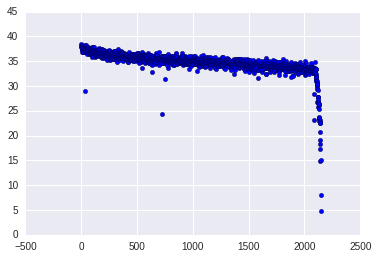

In [223]:
perf = np.array(list(map(evaluate_bag, evolved_pop)))
plt.scatter(np.arange(0, len(evolved_pop)), perf);

In [224]:
evolved_pop = evolved_pop[perf > 30.]

** Simulated Annealing **

In [93]:
def anneal(bag, modified_max_item_possible):
    
    def acceptance_probability(old_cost, new_cost, T):
        return np.exp((old_cost - new_cost) / T) 
    
    old_cost = evaluate_bag(bag)
    T = 1.0 # Temperature
    T_min = 0.00001
    alpha = 0.9
    
    while T > T_min:
        i = 1
        
        while i <= 2:
            new_solution = mutate([bag], modified_max_item_possible)[0]
            new_cost = evaluate_bag(new_solution)
            ap = acceptance_probability(old_cost, new_cost, T)
            
            if ap > np.random.random():
                bag = new_solution
                old_cost = new_cost
            i += 1
        T = T*alpha
    
    return bag, old_cost

In [98]:
pop = population(100, modified_max_item_possible)
annealed_pop = np.array([anneal(individual, modified_max_item_possible) for individual in pop])

In [100]:
annealed_pop

array([[array([2, 0, 0, 0, 0, 2, 6, 0, 1]), 31.631642642483015],
       [array([3, 0, 1, 0, 0, 1, 3, 2, 1]), 24.834382755063416],
       [array([2, 0, 0, 2, 0, 0, 5, 0, 0]), 14.635774147822255],
       [array([5, 0, 1, 3, 0, 1, 1, 2, 1]), 10.072507492274777],
       [array([2, 0, 1, 5, 0, 2, 1, 0, 1]), 25.934761785307362],
       [array([0, 0, 1, 0, 0, 2, 5, 2, 1]), 21.832136837936822],
       [array([2, 0, 1, 4, 0, 1, 2, 0, 0]), 30.816866071518728],
       [array([5, 0, 1, 0, 0, 1, 7, 2, 0]), 29.455262997151891],
       [array([5, 0, 0, 4, 0, 2, 2, 0, 1]), 22.733412007012568],
       [array([0, 0, 1, 0, 0, 0, 1, 1, 0]), 17.7055554119639],
       [array([0, 0, 1, 2, 0, 2, 0, 1, 1]), 23.996513822354633],
       [array([3, 0, 1, 5, 0, 2, 2, 0, 1]), 19.83070042545884],
       [array([3, 0, 0, 3, 0, 0, 3, 0, 0]), 12.141998844905359],
       [array([1, 0, 1, 0, 0, 1, 6, 0, 1]), 34.220722947348342],
       [array([5, 0, 0, 5, 0, 2, 2, 2, 0]), 32.223831825890542],
       [array([1, 0, 1, 4, 0

** Method 3 **

In [100]:
def create_initial_candidates(max_item_count):
    """
    Based on the max permissible item count, we can generate initial candidates
    for each of the gift types.
    
    e.g. Only 26 horses can be included in a single bag such that it won't overshoot the
    total budget. so intial candidate would be something like
    """
    candidates = []
    
    for i in range(len(max_item_count)):
        max_possible_item = np.zeros(shape=(len(max_item_count), ))
        max_possible_item[i] = max_item_count[i]
        
        candidates.append(max_possible_item)
    
    return np.array(candidates)

In [27]:
def generate_solutions(max_item_count):
    def evaluate_neighbors(neighbors):
        perf = np.array([(neighbor, objective_function(neighbor, 1000)) \
                         for neighbor in neighbors])
        
        return perf[perf[:, 1] >= 28.][:, 0]
    
    solutions = []
    candidates = create_initial_candidates(max_item_count)
    
    for i in range(0, 9):
        
        queue     = []
        queue.append(candidates[i])
        n_iterations = 0
        
        while True and n_iterations <= 1000 and len(queue) > 0:
            print('total solutions till now ', len(solutions))
            next_candidate = queue.pop()

            if next_candidate[i] <= 0:
                break

            neighbors = generate_neighbors(next_candidate, i)
            neighbors_survived = evaluate_neighbors(neighbors)
            
            if len(neighbors_survived) < 2:
                perturbation_vector = np.zeros(shape=(9, ))
                perturbation_vector[i] = -1

                queue.append(next_candidate + perturbation_vector)
            else:
                
                for survivor in neighbors_survived:
                    
                    if len(solutions) > 0:

                        if np.sum(np.all(survivor == solutions, axis=1)) == 0:
                            solutions.append(survivor)
                            queue.append(survivor)
                    else:
                        solutions.append(survivor)
                        queue.append(survivor)
                                        
            n_iterations += 1
            
    return solutions

def repeat_solutions(df, available_count):
    solution_space = []
    for i in range(len(df)):
        mask = (df.iloc[i] > 0).values
        repeat_count = np.min((available_count[mask] / df.iloc[i][mask]).map(np.floor))
        solution_space.append(np.repeat([df.iloc[i].values], repeat_count, axis=0))
    
    return np.vstack(solution_space)

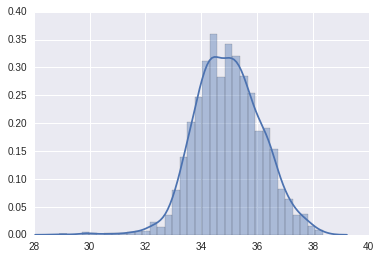

In [225]:
# solutions = generate_solutions(max_item_count)
df = pd.DataFrame(evolved_pop)
df = df.drop_duplicates()
sns.distplot(df.apply(evaluate_bag, axis=1));

In [226]:
# generate the total search space based on evaluation function
solution_space = repeat_solutions(df, available_count)

In [227]:
len(solution_space)

148573

__Given different bags choose those bags that would give us the maximum possible weight.__

In [30]:
def pack_linprog(bags, distributions, min_variance, max_bags=1000):
    # objective: c.T * x -> min
    c = - distributions[:,0] # optimize sum of expected bag utilities
    
    # constraint: A_ub * x <= b_ub
    A_ub = bags.T # don't use more gifts than available
    b_ub = np.array([num_gifts_available[gift] for gift in gift_types])
    
    A_ub = np.vstack([A_ub, np.ones(A_ub.shape[1])]) # pack at most max_bags gifts
    b_ub = np.hstack([b_ub, [max_bags]])
    
    if min_variance is not None:
        A_ub = np.vstack([A_ub, -distributions[:,1]]) # require minimum variance
        b_ub = np.hstack([b_ub, [-min_variance]])
    
    result = sp.optimize.linprog(c, A_ub=A_ub, b_ub=b_ub)
    if result["success"] == False:
        return [], True
    else:
        return result["x"].astype('int64'), False


def pack_bags(bags, distributions, min_variance=None):
    max_bags = 1000
    bag_quantities, infeasible = pack_linprog(bags, distributions, min_variance=min_variance)
    while np.sum(bag_quantities) < 1000:
        max_bags += 1
        bag_quantities, infeasible = pack_linprog(bags, distributions, min_variance=min_variance, max_bags=max_bags)
        if max_bags > 1015:
            print("WARNING: not getting 1000 bags")
            break
        if infeasible:
            continue
    
    if infeasible:
        print("infeasible")
        return [], [], []
    
    chosen_bag_idx = np.where(bag_quantities)[0]
    chosen_bags = bags[chosen_bag_idx]
    chosen_distributions = distributions[chosen_bag_idx]
    chosen_quantities = bag_quantities[chosen_bag_idx]
    
    while np.sum(chosen_quantities) > 1000:
        idx = np.random.randint(len(chosen_quantities))
        chosen_quantities[idx] = max (chosen_quantities[idx]-1, 0)
    
    score_distribution = np.dot(chosen_quantities, chosen_distributions)
    print("{} bags - score distribution: mean = {:.2f} | var = {:.2f}"
          .format(np.sum(chosen_quantities), score_distribution[0], score_distribution[1]))
    
    return chosen_bags, chosen_distributions, chosen_quantities

In [228]:
bag_utility_distributions = get_bag_utility_distributions(solution_space)
packed_bags, packed_distributions, packed_quantities \
    = pack_bags(solution_space, bag_utility_distributions, min_variance=None)

0.0000
0.0471
0.0942
0.1413
0.1885
0.2356
0.2827
0.3298
0.3769
0.4240
0.4711
0.5183
0.5654
0.6125
0.6596
0.7067
0.7538
0.8010
0.8481
0.8952
0.9423
0.9894

1000 bags - score distribution: mean = 35746.19 | var = 65204.95


__Create different submissions__

In [199]:
def create_submissions(bags, quantities, num_submissions=5):
    def create_stock(n):
        stock = { gift: list(map(lambda id: "{}_{}".format(gift, id) ,np.arange(num_gifts_available[gift]))) for gift in gift_types }
        return shuffle(stock, n)
    
    def shuffle(stock, seed):
        np.random.seed(seed)
        for gift in stock.keys():
            np.random.shuffle(stock[gift])
        return stock
    
    def generate_submission(n):
        from datetime import datetime
        curr_time_str = datetime.today().strftime("%B %d, %Y %H:%M:%S")
        
        stock = create_stock(n)
        with open("../submissions/submission_without_coal_{}_{}.csv".format(curr_time_str, n), 'w+') as submission_file:
            submission_file.write('Gifts\n')
            for i in range(len(bags)):
                for quantity in range(quantities[i]):
                    current_gifts = bags[i]
                    for gift_idx, gift_quantity in enumerate(current_gifts[:len(gift_types)]):
                        gift_name = gift_types[gift_idx]
                        for j in range(int(gift_quantity)):
                            submission_file.write("{} ".format(stock[gift_name].pop()))
                    submission_file.write("\n")
    
    for n in range(num_submissions):
        generate_submission(n)

In [200]:
create_submissions(packed_bags, packed_quantities)

### Leaderboard Summary

1. Score for one of the submissions: __34418.20039__
2. Score for one of the submission with updated max count: __34573.07771__